# Utilizando modelos do Hugging Face

In [10]:
!pip install torch transformers numpy pandas matplotlib sklearn tqdm ipywidgets --quiet

In [1]:
import torch
device = "cuda" if torch.cuda.is_available() else "cpu"
from transformers import AutoTokenizer

In [2]:
model_name = "neuralmind/bert-base-portuguese-cased"

tokenizer = AutoTokenizer.from_pretrained(model_name)

## Tokenizer

In [8]:
tokens_pt = tokenizer("Esse é um exemplo", return_tensors="pt")

for key, value in tokens_pt.items():
    print("{}:\n\n\t{}\n".format(key, value))

input_ids:

	tensor([[ 101, 3758,  253,  222, 1416,  102]])

token_type_ids:

	tensor([[0, 0, 0, 0, 0, 0]])

attention_mask:

	tensor([[1, 1, 1, 1, 1, 1]])



In [9]:
tokens = tokenizer(
    ["Essa é uma amostra", "O Grupo Turing é legal"], 
    padding=True
)

for i in range(2):
    print("Tokens (int)      : {}".format(tokens['input_ids'][i]))
    print("Tokens (str)      : {}".format([tokenizer.convert_ids_to_tokens(s) for s in tokens['input_ids'][i]]))
    print("Tokens (attn_mask): {}".format(tokens['attention_mask'][i]))
    print()

Tokens (int)      : [101, 3311, 253, 230, 11303, 102, 0]
Tokens (str)      : ['[CLS]', 'Essa', 'é', 'uma', 'amostra', '[SEP]', '[PAD]']
Tokens (attn_mask): [1, 1, 1, 1, 1, 1, 0]

Tokens (int)      : [101, 231, 3722, 19542, 253, 7103, 102]
Tokens (str)      : ['[CLS]', 'O', 'Grupo', 'Turing', 'é', 'legal', '[SEP]']
Tokens (attn_mask): [1, 1, 1, 1, 1, 1, 1]



## Dados

Dataset: https://github.com/b2wdigital/b2w-reviews01

In [10]:
#!wget https://raw.githubusercontent.com/b2wdigital/b2w-reviews01/master/B2W-Reviews01.csv

In [4]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

In [12]:
df = pd.read_csv('B2W-Reviews01.csv', delimiter=';', low_memory=False);

In [13]:
df.shape

(132373, 14)

In [14]:
df.head()

,submission_date,reviewer_id,product_id,product_name,product_brand,site_category_lv1,site_category_lv2,review_title,overall_rating,recommend_to_a_friend,review_text,reviewer_birth_year,reviewer_gender,reviewer_state
0,2018-01-01 00:11:28,d0fb1ca69422530334178f5c8624aa7a99da47907c44de...,132532965,Notebook Asus Vivobook Max X541NA-GO472T Intel...,NaN,Informática,Notebook,Bom,4,Yes,Estou contente com a compra entrega rápida o ú...,1958.0,F,RJ
1,2018-01-01 00:13:48,014d6dc5a10aed1ff1e6f349fb2b059a2d3de511c7538a...,22562178,Copo Acrílico Com Canudo 500ml Rocie,NaN,Utilidades Domésticas,"Copos, Taças e Canecas","Preço imbatível, ótima qualidade",4,Yes,"Por apenas R$1994.20,eu consegui comprar esse ...",1996.0,M,SC
2,2018-01-01 00:26:02,44f2c8edd93471926fff601274b8b2b5c4824e386ae4f2...,113022329,Panela de Pressão Elétrica Philips Walita Dail...,philips walita,Eletroportáteis,Panela Elétrica,ATENDE TODAS AS EXPECTATIVA.,4,Yes,SUPERA EM AGILIDADE E PRATICIDADE OUTRAS PANEL...,1984.0,M,SP
3,2018-01-01 00:35:54,ce741665c1764ab2d77539e18d0e4f66dde6213c9f0863...,113851581,Betoneira Columbus - Roma Brinquedos,roma jensen,Brinquedos,Veículos de Brinquedo,presente mais que desejado,4,Yes,MEU FILHO AMOU! PARECE DE VERDADE COM TANTOS D...,1985.0,F,SP
4,2018-01-01 01:00:28,7d7b6b18dda804a897359276cef0ca252f9932bf4b5c8e...,131788803,"Smart TV LED 43"" LG 43UJ6525 Ultra HD 4K com C...",lg,TV e Home Theater,TV,"Sem duvidas, excelente",5,Yes,"A entrega foi no prazo, as americanas estão de...",1994.0,M,MG


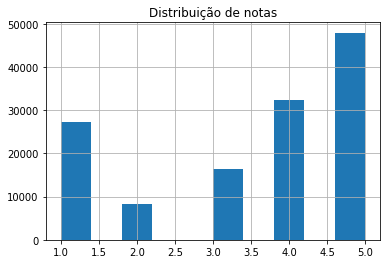

In [15]:
df.overall_rating.hist()
plt.title('Distribuição de notas');

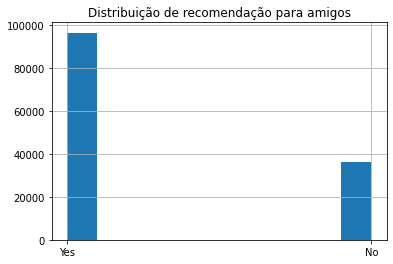

In [16]:
df.recommend_to_a_friend.hist()
plt.title('Distribuição de recomendação para amigos');

In [17]:
def mask(df, key, value):
     return df[df[key] == value]
    
pd.DataFrame.mask = mask

def show_review_example(reviews, rating, recommend):
    
    ratings = {
        1: 'Ruim',
        2: 'Regular',
        3: 'Bom',
        4: 'Ótimo',
        5: 'Excelente'
    }
    
    recommendations = {
        'Yes': 'Sim',
        'No': 'Não'
    }
    
    rating_reviews = reviews.mask('overall_rating', rating).mask('recommend_to_a_friend', recommend)
    
    example = rating_reviews.sample().iloc[0]
    
    review_text = example['review_text']
    review_rating = ratings[example['overall_rating']]
    review_recommendation = recommendations[example['recommend_to_a_friend']]
    
    print('Review: ', review_text)
    print('Nota: ', review_rating)
    print('Recomendação: ', review_recommendation)

In [18]:
show_review_example(df, rating = 5, recommend = 'Yes')

Review:  Comprei para o espaço gourmet. Ficou lindo. Ótima qualidade. Super Recomendo!
Nota:  Excelente
Recomendação:  Sim


In [19]:
reviews = pd.DataFrame()

reviews['review_text'] = df.review_text.copy()

reviews.loc[:, 'overall_rating'] = df.overall_rating.apply(lambda rating: 1 if rating >= 3 else 0).copy()

reviews.loc[:, 'recommend_to_a_friend'] = df.recommend_to_a_friend.apply(lambda recommend: 1 if recommend == 'Yes' else 0).copy()

In [20]:
reviews.head()

,review_text,overall_rating,recommend_to_a_friend
0,Estou contente com a compra entrega rápida o ú...,1,1
1,"Por apenas R$1994.20,eu consegui comprar esse ...",1,1
2,SUPERA EM AGILIDADE E PRATICIDADE OUTRAS PANEL...,1,1
3,MEU FILHO AMOU! PARECE DE VERDADE COM TANTOS D...,1,1
4,"A entrega foi no prazo, as americanas estão de...",1,1


## Dataset e Dataloader

In [5]:
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split

In [25]:
class AmericanasDataset(Dataset):
    def __init__(self, dataframe, tokenizer):
        super(AmericanasDataset, self).__init__()
        
        X = dataframe['review_text'].to_list()
        y = dataframe['recommend_to_a_friend'].to_list()
        
        tokens = tokenizer(X, return_tensors='pt', max_length=110, padding=True, truncation=True).to(device)
        
        self.input_ids = tokens['input_ids']
        self.attention_mask = tokens['attention_mask']
        
        self.y = torch.Tensor(y).to(device)

    def __len__(self):
        return len(self.input_ids)

    def __getitem__(self, index):
        return (self.input_ids[index], self.attention_mask[index], self.y[index])
    

In [26]:
reviews_train, reviews_test = train_test_split(reviews, test_size=0.1, random_state=42)

In [27]:
reviews_train_dataset = AmericanasDataset(reviews_train, tokenizer)

In [28]:
data_loader = DataLoader(reviews_train_dataset, batch_size=64)

## Modelo

In [6]:
from transformers import AutoModel

In [30]:
model_name = "neuralmind/bert-base-portuguese-cased"

model = AutoModel.from_pretrained(model_name)

Downloading:   0%|          | 0.00/438M [00:00<?, ?B/s]

In [31]:
print(model)

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(29794, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0): BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
          

In [32]:
del(model)

## Transfer Learning

In [7]:
from torch import nn
from transformers import BertModel
from tqdm import tqdm
from sklearn.metrics import classification_report

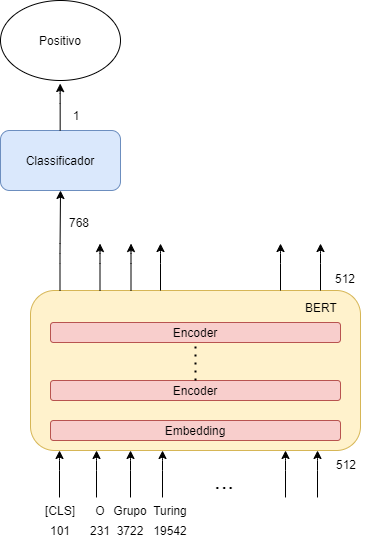

In [34]:
class CustomBERTModel(nn.Module):
    
    def __init__(self, bert_name_or_path, freeze_training = True):
        super(CustomBERTModel, self).__init__()
        
        # Bert
        self.bert = self._load_bert_(bert_name_or_path, freeze_training)

        # Classifier
        self.linear1 = nn.Linear(768, 256)
        self.linear2 = nn.Linear(256, 64)
        self.linear3 = nn.Linear(64, 1)
        
        
    def _load_bert_(self, bert_name_or_path, freeze_training):
        
        bert = BertModel.from_pretrained(bert_name_or_path)
        
        if freeze_training:
            for param in bert.parameters():
                param.requires_grad = False
                
        return bert
    
    def forward(self, ids, mask):
        
        bert_output = self.bert(ids, mask)
        
        # dim = (batch_size, sequence_length, hidden_size)
        sequence_output = bert_output['last_hidden_state']
        
        linear1_output = self.linear1(sequence_output[:, 0, :].view(-1, 768))

        linear2_output = self.linear2(linear1_output)
        
        linear3_output = self.linear3(linear2_output)

        return torch.sigmoid(linear3_output)
    
    def predict(self, reviews):
        
        tokens = tokenizer(reviews, return_tensors='pt', max_length=110, padding=True, truncation=True).to(device)
        
        input_ids = tokens['input_ids']
        attention_mask = tokens['attention_mask']
        
        output = self.forward(input_ids, attention_mask)
        
        return output[:, 0].cpu().detach().numpy()
        
        

In [35]:
model_name = "neuralmind/bert-base-portuguese-cased"
custom_model = CustomBERTModel(model_name, freeze_training = True)
custom_model.to(device)

criterion = nn.BCELoss()
optimizer = torch.optim.Adam(custom_model.parameters())

In [ ]:
epochs = range(3)

for epoch in epochs:    
    with tqdm(data_loader, unit=" batches") as tepoch:
        
        losses = []
        
        for batch in tepoch:
            
            tepoch.set_description(f"Epoch {epoch}")
        
            input_ids, attention_mask, y = batch

            optimizer.zero_grad()   

            y_hat = custom_model(ids=input_ids, mask=attention_mask).squeeze()

            loss = criterion(y_hat, y)

            loss.backward()
            optimizer.step()
            
            losses.append(loss.item())
            mean_loss = np.mean(losses)
            
            tepoch.set_postfix(loss=mean_loss)

In [28]:
torch.save(custom_model.state_dict(), 'bert3.pth')

In [29]:
custom_model.predict(['O produto tem uma ótima qualidade mas o atendimento foi mediano', 'ótimo produto!', 'péssimo produto e atendimento pior ainda', 'atendimento de bosta'])

array([0.9354642 , 0.99537104, 0.01967979, 0.09737755], dtype=float32)

In [30]:
reviews_test.head()

,review_text,overall_rating,recommend_to_a_friend
328,"Ele e muito bom ,bom, bom , bom , bom. BOM BOM...",1,1
83773,cumpre a funcao desejada melhor que a marca co...,1,1
117905,Não tem luz então não funciona a noite. Sem ma...,0,0
47675,"Lindo painel,material de qualidade,forte e res...",1,1
51037,Muito boa a lente estabilização e foco m...,1,1


In [25]:
custom_model.load_state_dict(torch.load('bert2.pth'))

<All keys matched successfully>

In [31]:
def get_predictions(reviews, model, threshold = 0.5):
    
    reviews_text = reviews.review_text.to_list()
    
    model_output = model.predict(reviews_text)
    
    predictions = model_output > threshold
    
    return predictions

In [34]:
n_samples = 1000

y_hat = get_predictions(reviews_test.iloc[:n_samples], custom_model)
y = reviews_test.iloc[:n_samples].recommend_to_a_friend

In [35]:
report = classification_report(y, y_hat, target_names=['Review Negativo', 'Review Positivo'])

print(report)

                 precision    recall  f1-score   support

Review Negativo       0.82      0.88      0.85       267
Review Positivo       0.96      0.93      0.94       733

       accuracy                           0.92      1000
      macro avg       0.89      0.91      0.90      1000
   weighted avg       0.92      0.92      0.92      1000

